In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
import pandas as pd
import sys
from tqdm import tqdm_notebook as tqdm
import copy
import os.path as osp
%run ./plot_functions.ipynb
sys.path.insert(0, '../src/')


output_path =  ../output/figures
plt = single_column_plt_params(plt)
plt = double_column_plt_params(plt)


In [2]:
from benchmark_utilities import benchmark_pnml, cat_benchmark_df
from baseline_utilities import odin_df_densnet_cifar10, odin_df_densnet_cifar100, odin_df_resnet_cifar10, odin_df_resnet_cifar100
from baseline_utilities import lvo_df_densnet_cifar10, lvo_df_densnet_cifar100, lvo_df_resnet_cifar10, lvo_df_resnet_cifar100
plt = single_column_plt_params(plt)


In [3]:
base_dir = osp.join('..', 'output', 'embedding')
ood_name_benchmark_list = ['Imagenet (crop)',
                           'Imagenet (resize)',
                           'LSUN (crop)',
                           'LSUN (resize)',
                           'iSUN', 'Uniform',
                           'Gaussian']


## Densnet CIFAR100

In [4]:
pnml_df_densnet_cifar100, results_densnet_cifar100_dict = benchmark_pnml(ood_name_benchmark_list,
                                                                         'DensNet-BC CIFAR100',
                                                                         base_dir)
pnml_df_densnet_cifar100


benchmark_pnml. model_name=DensNet-BC CIFAR100
Imagenet (crop)


100%|██████████| 100/100 [00:00<00:00, 134735.11it/s]

Imagenet (resize)



100%|██████████| 100/100 [00:00<00:00, 296836.80it/s]

LSUN (crop)



100%|██████████| 100/100 [00:00<00:00, 249364.09it/s]

LSUN (resize)



100%|██████████| 100/100 [00:00<00:00, 231473.73it/s]

iSUN



100%|██████████| 100/100 [00:00<00:00, 290464.27it/s]

Uniform



100%|██████████| 100/100 [00:00<00:00, 239811.55it/s]

Gaussian


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,DensNet-BC CIFAR100,Imagenet (crop),pNML,0.0,2.5,99.992879,99.993163,99.992733
1,DensNet-BC CIFAR100,Imagenet (resize),pNML,0.0,2.5,99.997560,99.997596,99.997544
2,DensNet-BC CIFAR100,LSUN (crop),pNML,0.0,2.5,99.964511,99.969121,99.961307
3,DensNet-BC CIFAR100,LSUN (resize),pNML,0.0,2.5,99.999332,99.999335,99.999331
4,DensNet-BC CIFAR100,iSUN,pNML,0.0,2.5,99.999012,99.999019,99.999009
5,DensNet-BC CIFAR100,Uniform,pNML,0.0,2.5,100.000000,100.000000,100.000000
6,DensNet-BC CIFAR100,Gaussian,pNML,0.0,2.5,100.000000,100.000000,100.000000


In [5]:
result_densnet_cifar100 = cat_benchmark_df(odin_df_densnet_cifar100,
                                           lvo_df_densnet_cifar100,
                                           pnml_df_densnet_cifar100)
result_densnet_cifar100


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,DensNet-BC CIFAR100,Imagenet (crop),ODIN,17.3,11.2,97.1,97.4,96.8
0,DensNet-BC CIFAR100,Imagenet (crop),LOO,8.3,6.3,98.4,98.6,98.3
0,DensNet-BC CIFAR100,Imagenet (crop),pNML,0.0,2.5,100.0,100.0,100.0
1,DensNet-BC CIFAR100,Imagenet (resize),ODIN,44.3,24.6,90.7,91.4,90.1
1,DensNet-BC CIFAR100,Imagenet (resize),LOO,20.5,10.0,96.3,96.7,95.8
1,DensNet-BC CIFAR100,Imagenet (resize),pNML,0.0,2.5,100.0,100.0,100.0
2,DensNet-BC CIFAR100,LSUN (crop),ODIN,17.6,11.3,96.8,97.1,96.5
2,DensNet-BC CIFAR100,LSUN (crop),LOO,14.7,8.5,97.4,97.6,97.2
2,DensNet-BC CIFAR100,LSUN (crop),pNML,0.0,2.5,100.0,100.0,100.0
3,DensNet-BC CIFAR100,LSUN (resize),ODIN,44.0,24.5,91.5,92.4,90.6


## Densnet CIFAR10

In [6]:
pnml_df_densnet_cifar10, results_densnet_cifar10_dict = benchmark_pnml(ood_name_benchmark_list,
                                                                       'DensNet-BC CIFAR10',
                                                                       base_dir)
pnml_df_densnet_cifar10


  0%|          | 0/10 [00:00<?, ?it/s]

benchmark_pnml. model_name=DensNet-BC CIFAR10
Imagenet (crop)


100%|██████████| 10/10 [00:00<00:00, 40960.00it/s]

Imagenet (resize)



100%|██████████| 10/10 [00:00<00:00, 28807.03it/s]

LSUN (crop)



100%|██████████| 10/10 [00:00<00:00, 43645.20it/s]

LSUN (resize)



100%|██████████| 10/10 [00:00<00:00, 25373.89it/s]

iSUN



100%|██████████| 10/10 [00:00<00:00, 46603.38it/s]

Uniform



100%|██████████| 10/10 [00:00<00:00, 38764.36it/s]

Gaussian


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,DensNet-BC CIFAR10,Imagenet (crop),pNML,0.0,2.5,100.0,100.0,100.0
1,DensNet-BC CIFAR10,Imagenet (resize),pNML,0.0,2.5,100.0,100.0,100.0
2,DensNet-BC CIFAR10,LSUN (crop),pNML,0.0,2.5,100.0,100.0,100.0
3,DensNet-BC CIFAR10,LSUN (resize),pNML,0.0,2.5,100.0,100.0,100.0
4,DensNet-BC CIFAR10,iSUN,pNML,0.0,2.5,100.0,100.0,100.0
5,DensNet-BC CIFAR10,Uniform,pNML,0.0,2.5,100.0,100.0,100.0
6,DensNet-BC CIFAR10,Gaussian,pNML,0.0,2.5,100.0,100.0,100.0


In [7]:
result_densnet_cifar10 = cat_benchmark_df(odin_df_densnet_cifar10,
                                          lvo_df_densnet_cifar10,
                                          pnml_df_densnet_cifar10)
result_densnet_cifar10


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,DensNet-BC CIFAR10,Imagenet (crop),ODIN,4.3,4.7,99.1,99.1,99.1
0,DensNet-BC CIFAR10,Imagenet (crop),LOO,1.2,2.6,99.6,99.7,99.6
0,DensNet-BC CIFAR10,Imagenet (crop),pNML,0.0,2.5,100.0,100.0,100.0
1,DensNet-BC CIFAR10,Imagenet (resize),ODIN,7.5,6.3,98.5,98.6,98.5
1,DensNet-BC CIFAR10,Imagenet (resize),LOO,2.9,3.8,99.3,99.4,99.3
1,DensNet-BC CIFAR10,Imagenet (resize),pNML,0.0,2.5,100.0,100.0,100.0
2,DensNet-BC CIFAR10,LSUN (crop),ODIN,8.7,6.9,98.2,98.5,97.8
2,DensNet-BC CIFAR10,LSUN (crop),LOO,3.4,4.1,99.2,99.3,99.2
2,DensNet-BC CIFAR10,LSUN (crop),pNML,0.0,2.5,100.0,100.0,100.0
3,DensNet-BC CIFAR10,LSUN (resize),ODIN,3.8,4.4,99.2,99.3,99.2


# Resnet CIFAR 10

In [8]:
pnml_df_resnet_cifar10, results_resnet_cifar10_dict = benchmark_pnml(ood_name_benchmark_list,
                                                                     'WRN-28-10 CIFAR10',
                                                                     base_dir)
pnml_df_resnet_cifar10


benchmark_pnml. model_name=WRN-28-10 CIFAR10
Imagenet (crop)


100%|██████████| 10/10 [00:00<00:00, 24571.20it/s]

Imagenet (resize)



100%|██████████| 10/10 [00:00<00:00, 53773.13it/s]

LSUN (crop)



100%|██████████| 10/10 [00:00<00:00, 32793.62it/s]

LSUN (resize)



100%|██████████| 10/10 [00:00<00:00, 55849.59it/s]

iSUN



100%|██████████| 10/10 [00:00<00:00, 31944.43it/s]

Uniform



100%|██████████| 10/10 [00:00<00:00, 69788.75it/s]

Gaussian


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,WRN-28-10 CIFAR10,Imagenet (crop),pNML,0.0,2.5,100.0,100.0,100.0
1,WRN-28-10 CIFAR10,Imagenet (resize),pNML,0.0,2.5,100.0,100.0,100.0
2,WRN-28-10 CIFAR10,LSUN (crop),pNML,0.0,2.5,100.0,100.0,100.0
3,WRN-28-10 CIFAR10,LSUN (resize),pNML,0.0,2.5,100.0,100.0,100.0
4,WRN-28-10 CIFAR10,iSUN,pNML,0.0,2.5,100.0,100.0,100.0
5,WRN-28-10 CIFAR10,Uniform,pNML,0.0,2.5,100.0,100.0,100.0
6,WRN-28-10 CIFAR10,Gaussian,pNML,0.0,2.5,100.0,100.0,100.0


In [9]:
result_resnet_cifar10 = cat_benchmark_df(odin_df_resnet_cifar10,
                                         lvo_df_resnet_cifar10,
                                         pnml_df_resnet_cifar10)
result_resnet_cifar10


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,WRN-28-10 CIFAR10,Imagenet (crop),ODIN,23.4,14.2,94.2,92.8,94.7
0,WRN-28-10 CIFAR10,Imagenet (crop),LOO,0.8,2.2,99.8,99.8,99.8
0,WRN-28-10 CIFAR10,Imagenet (crop),pNML,0.0,2.5,100.0,100.0,100.0
1,WRN-28-10 CIFAR10,Imagenet (resize),ODIN,25.5,15.2,92.1,89.0,93.6
1,WRN-28-10 CIFAR10,Imagenet (resize),LOO,2.9,3.8,99.4,99.4,99.4
1,WRN-28-10 CIFAR10,Imagenet (resize),pNML,0.0,2.5,100.0,100.0,100.0
2,WRN-28-10 CIFAR10,LSUN (crop),ODIN,21.8,13.4,95.9,95.8,95.5
2,WRN-28-10 CIFAR10,LSUN (crop),LOO,1.9,3.2,99.6,99.6,99.6
2,WRN-28-10 CIFAR10,LSUN (crop),pNML,0.0,2.5,100.0,100.0,100.0
3,WRN-28-10 CIFAR10,LSUN (resize),ODIN,17.6,11.3,95.4,93.8,96.1


# ResNet CIFAR100

In [10]:
pnml_df_resnet_cifar100, results_resnet_cifar100_dict = benchmark_pnml(ood_name_benchmark_list,
                                                                       'WRN-28-10 CIFAR100',
                                                                       base_dir)
pnml_df_resnet_cifar100


benchmark_pnml. model_name=WRN-28-10 CIFAR100
Imagenet (crop)


100%|██████████| 100/100 [00:05<00:00, 19.24it/s]


Imagenet (resize)


100%|██████████| 100/100 [00:00<00:00, 197193.42it/s]


LSUN (crop)


100%|██████████| 100/100 [00:00<00:00, 96332.20it/s]


LSUN (resize)


100%|██████████| 100/100 [00:00<00:00, 310459.22it/s]

iSUN



100%|██████████| 100/100 [00:00<00:00, 253279.23it/s]

Uniform



100%|██████████| 100/100 [00:00<00:00, 212262.35it/s]

Gaussian


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,WRN-28-10 CIFAR100,Imagenet (crop),pNML,0.0,2.5,99.999992,99.999992,99.999992
1,WRN-28-10 CIFAR100,Imagenet (resize),pNML,0.0,2.5,100.000000,100.000000,100.000000
2,WRN-28-10 CIFAR100,LSUN (crop),pNML,0.0,2.5,100.000000,100.000000,100.000000
3,WRN-28-10 CIFAR100,LSUN (resize),pNML,0.0,2.5,99.999997,99.999997,99.999997
4,WRN-28-10 CIFAR100,iSUN,pNML,0.0,2.5,99.999996,99.999996,99.999996
5,WRN-28-10 CIFAR100,Uniform,pNML,0.0,2.5,99.999948,99.999948,99.999948
6,WRN-28-10 CIFAR100,Gaussian,pNML,0.0,2.5,99.999998,99.999998,99.999998


In [11]:
result_resnet_cifar100 = cat_benchmark_df(odin_df_resnet_cifar100,
                                          lvo_df_resnet_cifar100,
                                          pnml_df_resnet_cifar100)

result_resnet_cifar100


,Model,OOD Datasets,Method,FPR (95% TPR) ↓,Detection Error ↓,AUROC ↑,AP-In ↑,AP-Out ↑
0,WRN-28-10 CIFAR100,Imagenet (crop),ODIN,43.9,24.4,90.8,91.4,90.0
0,WRN-28-10 CIFAR100,Imagenet (crop),LOO,9.2,6.7,98.2,98.4,98.1
0,WRN-28-10 CIFAR100,Imagenet (crop),pNML,0.0,2.5,100.0,100.0,100.0
1,WRN-28-10 CIFAR100,Imagenet (resize),ODIN,55.9,30.4,84.0,82.8,84.4
1,WRN-28-10 CIFAR100,Imagenet (resize),LOO,24.5,11.6,95.2,95.5,94.8
1,WRN-28-10 CIFAR100,Imagenet (resize),pNML,0.0,2.5,100.0,100.0,100.0
2,WRN-28-10 CIFAR100,LSUN (crop),ODIN,39.6,22.3,92.0,92.4,91.6
2,WRN-28-10 CIFAR100,LSUN (crop),LOO,14.2,8.2,97.4,97.6,97.2
2,WRN-28-10 CIFAR100,LSUN (crop),pNML,0.0,2.5,100.0,100.0,100.0
3,WRN-28-10 CIFAR100,LSUN (resize),ODIN,56.5,30.8,86.0,86.2,84.9


# Summary

In [12]:
summary_df = pd.concat([result_densnet_cifar10,
                        result_densnet_cifar100,
                        result_resnet_cifar10,
                        result_resnet_cifar100])  # .reset_index(drop=True)

prev_row = summary_df.iloc[-1]['OOD Datasets']
change_idx = []
len_df = len(summary_df)
for iloc_idx in range(len_df):

    rev_idx = len_df - iloc_idx - 1
    row = summary_df.iloc[rev_idx]
    if row['OOD Datasets'] != prev_row:
        empty_row = pd.Series(None, index=[rev_idx+1])
        summary_df = pd.concat([summary_df.iloc[:rev_idx+1], empty_row,
                                summary_df.iloc[rev_idx+1:]]).reset_index(drop=True)
    prev_row = row['OOD Datasets']
summary_df.to_csv(osp.join('..', 'output', 'summary.csv'), index=False)


/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


# Visualize regret

<Figure size 460.8x316.8 with 0 Axes>

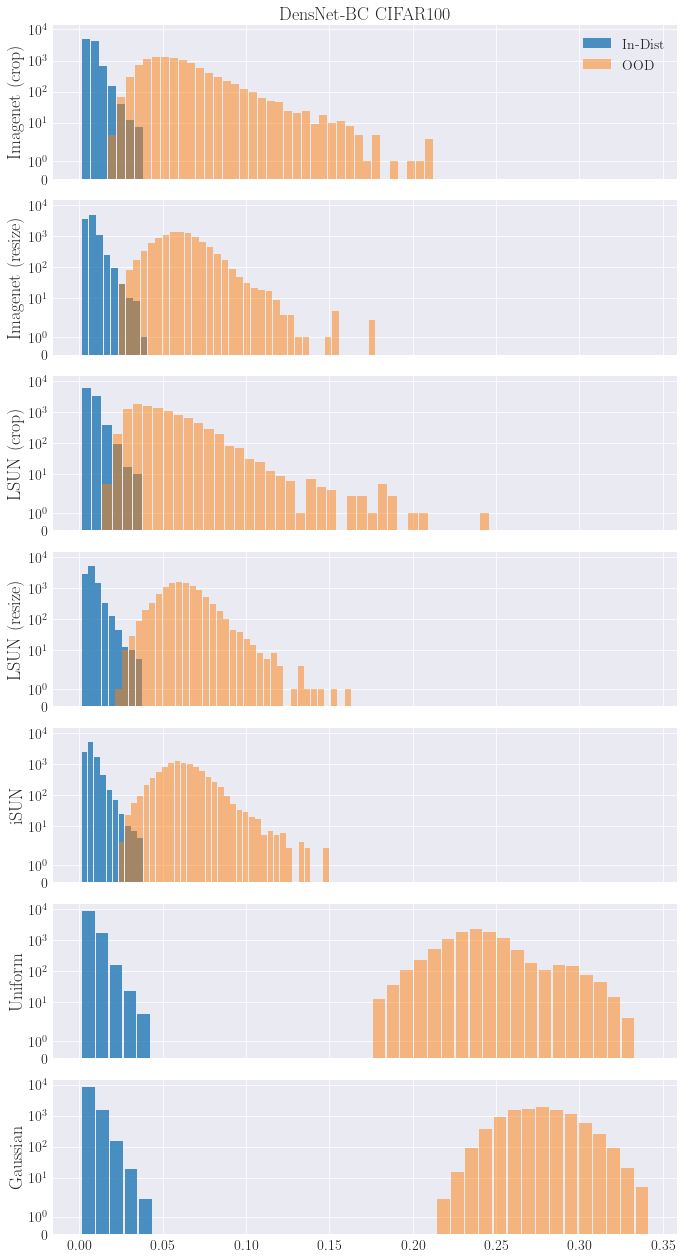

In [17]:
fig = plt.figure()
size = fig.get_size_inches()
dataset_num = len(results_densnet_cifar100_dict['regret'].keys())
fig, axs = plt.subplots(dataset_num, 1, figsize=(
    1.5*size[0], 4*size[1]), sharex=True, sharey=True)

df = results_densnet_cifar100_dict['regret']
for i, ood_name in enumerate(df.keys()):

    ind_np = df[ood_name]['IND']
    ood_np = df[ood_name]['OOD']

    bins = np.histogram(np.hstack((ind_np, ood_np)), bins=40)[1]
    axs[i].hist(ind_np, alpha=0.8, bins=bins, label='In-Dist',
                density=False, rwidth=0.9)
    axs[i].hist(ood_np, bins=bins, alpha=0.5, rwidth=0.9,
                label='OOD', density=False)
    axs[i].set_ylabel(ood_name)
    axs[i].set_yscale('symlog')


axs[0].legend()
axs[0].set_title('DensNet-BC CIFAR100')
plt.tight_layout()
plt.show()


<Figure size 460.8x316.8 with 0 Axes>

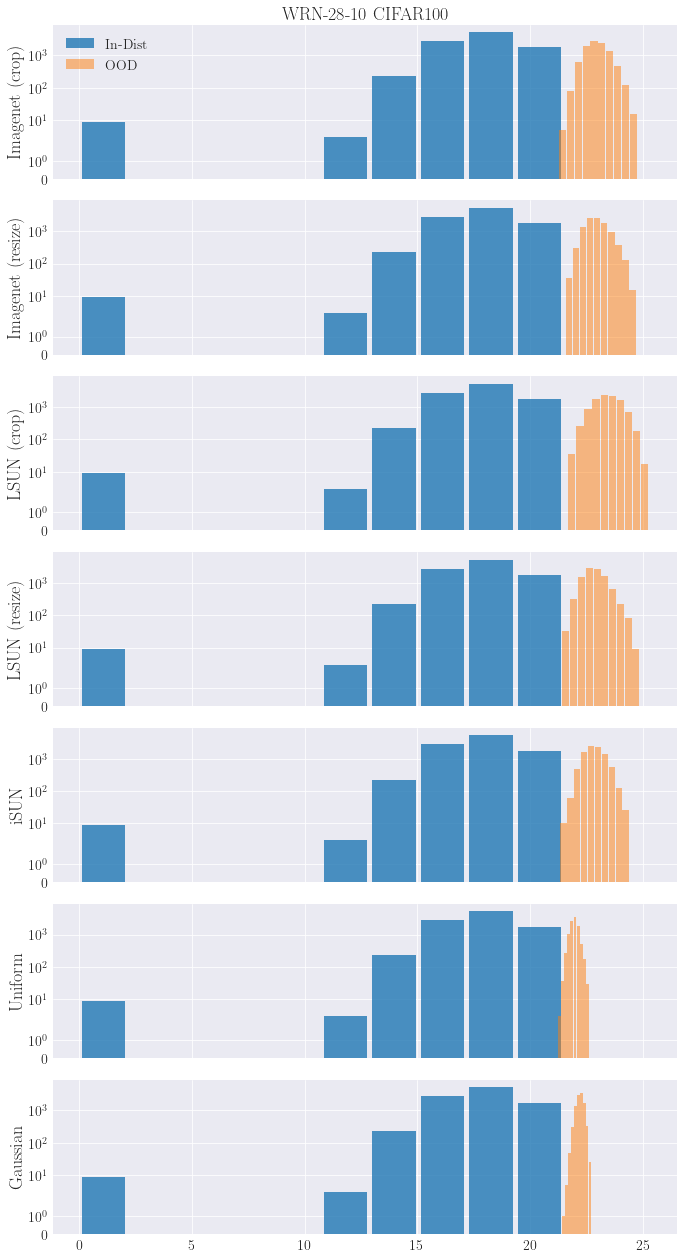

In [19]:
fig = plt.figure()
size = fig.get_size_inches()
df = results_resnet_cifar100_dict['regret']
dataset_num = len(df.keys())
fig, axs = plt.subplots(dataset_num, 1, figsize=(
    1.5*size[0], 4*size[1]), sharex=True, sharey=True)

for i, ood_name in enumerate(df.keys()):

    ind_np = df[ood_name]['IND']
    ood_np = df[ood_name]['OOD']

    bins = np.histogram(np.hstack((ind_np, ood_np)), bins=40)[1]
    axs[i].hist(ind_np, alpha=0.8,  label='In-Dist', #bins=bins,
                density=False, rwidth=0.9)
    axs[i].hist(ood_np,  alpha=0.5, rwidth=0.9, #bins=bins,
                label='OOD', density=False)
    axs[i].set_ylabel(ood_name)
    axs[i].set_yscale('symlog')


axs[0].legend()
axs[0].set_title('WRN-28-10 CIFAR100')
plt.tight_layout()
plt.show()


## Deep dive pNML

In [15]:
from distributions_metrics import calc_performance_in_out_dist


def compute_regret_deep_dive(x_m_train: np.ndarray, x_m_test: np.ndarray, lamb: float, u=None, eta=None, vh=None):
    n = x_m_train.shape[1]
    
    # SVD decomposition
    if u is None or eta is None or None or vh is None:
        u, s, vh = np.linalg.svd(x_m_train)
        eta = s ** 2

        # pad to fit u
        padded = np.zeros(u.shape[0])
        padded[:eta.shape[0]] = eta
        eta = padded

        eta = eta[:, np.newaxis]

    # Calc mean regret
    x_t_u_2 = (x_m_test.T.dot(u)) ** 2
    div = x_t_u_2 / (eta.T + lamb)
    regret_list = np.log(1 + (1 / n) * div.sum(axis=1)).tolist()
    return regret_list, u, eta, vh


In [16]:
pnml_dataset_input = resnet_cifar10_path_dict

pnml_dataset = copy.deepcopy(pnml_dataset_input)

# Get In-Distribution datasets
trainset_path = pnml_dataset['trainset']
train_labels_path = pnml_dataset['train_labels']
testset_path = pnml_dataset['testset']
trainset_all = np.load(trainset_path).T
testset_ind = np.load(testset_path).T
train_labels = np.load(train_labels_path)

# Initialize performance dataframe output
perf_df_list = []

# Iterate over Out-Of-Distribution datasets
ood_name = 'LSUN (resize)'
npy_path = pnml_dataset[ood_name]


print('pNML for {}'.format(ood_name))
testset_ood = np.load(npy_path).T

# testset_ind -= testset_ind.mean(axis=0)
# testset_ood -= testset_ood.mean(axis=0)


lamb = 0
for lamb in [1, 1e-1, 1e-3, 1e-6, 1e-9, 1e-12, 1e-16, 1e-19]:
    regret_ind_list_all = []
    regret_ood_list_all = []
    for class_num in tqdm(np.unique(train_labels)):
        trainset = trainset_all[:, train_labels == class_num]
    #     trainset -= trainset.mean(axis=0)

        regret_ind_list, u, eta, vh = compute_regret_deep_dive(
            trainset, testset_ind, lamb=lamb, u=None, eta=None, vh=None)
        regret_ood_list, _, _, _ = compute_regret_deep_dive(
            trainset, testset_ood, lamb=lamb, u=u, eta=eta, vh=vh)

        regret_ind_list_all.append(regret_ind_list)
        regret_ood_list_all.append(regret_ood_list)

    regret_ind_np = np.asarray(regret_ind_list_all)
    regret_ood_np = np.asarray(regret_ood_list_all)

    regret_ind_min_list = np.min(regret_ind_np, axis=0).tolist()
    regret_ood_min_list = np.min(regret_ood_np, axis=0).tolist()

    assert isinstance(regret_ind_min_list, list)
    assert isinstance(regret_ood_min_list, list)

    y_score_ind = regret_ind_min_list + regret_ood_min_list
    y_score_ind = 1 - np.array(y_score_ind)
    y_true_ind = [True] * len(regret_ind_min_list) + \
        [False] * len(regret_ood_min_list)
    performance = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    print('lamb: {} {}'.format(lamb, float(performance['AUROC ↑'])))


NameError: name 'resnet_cifar10_path_dict' is not defined

In [ ]:
print('Vanilla')
performance


In [ ]:
x_m_train = trainset
x_m_test = testset_ood[:, 0]
u = u
eta = eta
vh = vh
dim = dim
lamb = lamb
n = x_m_train.shape[1]

# SVD decomposition
if u is None or eta is None or None or vh is None:
    u, s, vh = np.linalg.svd(x_m_train)
    eta = s ** 2

    # pad to fit u
    padded = np.zeros(u.shape[0])
    padded[:eta.shape[0]] = eta
    eta = padded

    eta = eta[:, np.newaxis]

# Calc mean regret
x_t_u_2_ood = (x_m_test.T.dot(u)) ** 2
div_ood = x_t_u_2_ood / (eta.T + lamb)

regret_ood_list = np.log(1 + (1 / n) * div_ood.sum(axis=1)
                         ).tolist()  # div.sum(axis=1).tolist()


In [ ]:
x_m_train = trainset
x_m_test = testset_ind[:, 0]
u = u
eta = eta
vh = vh
dim = dim
lamb = 0#lamb
n = x_m_train.shape[1]

# SVD decomposition
if u is None or eta is None or None or vh is None:
    u, s, vh = np.linalg.svd(x_m_train)
    eta = s ** 2

    # pad to fit u
    padded = np.zeros(u.shape[0])
    padded[:eta.shape[0]] = eta
    eta = padded

    eta = eta[:, np.newaxis]

# Calc mean regret
x_t_u_2_ind = (x_m_test.T.dot(u)) ** 2
div_ind = x_t_u_2_ind / (eta.T + lamb)

# div_ind[div_ind == np.inf] = 10e12
# div_ind[div_ind==np.nan] = 10e12

# np.log(1 + (1 / n) * div.sum(axis=1)).tolist()
regret_ind_list = np.log(1 + (1 / n) * div_ind.sum(axis=1)).tolist() #div.sum(axis=1).tolist()


In [ ]:
plt.plot(x_t_u_2_ind)
plt.plot(x_t_u_2_ood)
plt.yscale('symlog')
plt.show()

In [ ]:
_,bins,_ = plt.hist(regret_ind_min_list,label='In')#, range=(0,1))
plt.hist(regret_ood_min_list,bins=bins,alpha=0.5,label='Out')
plt.legend()
plt.show()
